# Stream gauge/pixel correlations <img align="right" src="../../../Supplementary_data/dea_logo.jpg">

* **Compatibility:** Notebook currently compatible with both the NCI and DEA Sandbox environments. 
* **Products used:** 
[ga_ls7e_ard_3](https://explorer.sandbox.dea.ga.gov.au/ga_ls5t_ard_3),
[ga_ls7e_ard_3](https://explorer.sandbox.dea.ga.gov.au/ga_ls7e_ard_3),
[ga_ls7e_ard_3](https://explorer.sandbox.dea.ga.gov.au/ga_ls8c_ard_3)

## Description

Understanding the movement of floodwater throughout the landscape is critical to managing and tracking water in our important river basins. Tracking floodwater is hard though as satellite data are not always available and the flow of water through the landscape can be very complicated. It would be really nice if we could use stream gauges as a proxy for floodwater levels away from the streams they probe. Stream gauge data are readily available for many rivers and streams throughout the continent, and the data are well-sampled and reliable. This notebook estimates the linear correlation between Tasseled-Cap Wetness at a location and the height of nearby stream gauges.

## Getting started

Set the analysis parameters and then run all cells.

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import datacube
from tqdm.auto import tqdm
import geopandas as gpd
import shapely.geometry
import scipy.stats

import sys
sys.path.insert(1, '../Scripts')
import dea_bom
import dea_bandindices
import dea_datahandling

dc = datacube.Datacube(app="StreamPixelRelationships")

### Analysis parameters

Specify a region to analyse:

In [3]:
# Murray @ Colignan
southwest = -34.57521, 142.38599
northeast = -34.55259, 142.43062

ylim, xlim = zip(southwest, northeast)

## Querying the BOM

The Bureau of Meteorology keeps stream gauge data. Get all stream gauge stations:

In [4]:
stations = dea_bom.get_stations()

Then find all the stations in our analysis region:

In [5]:
stations_in_range = [s for s in stations if s.pos and ylim[0] <= s.pos[0] <= ylim[1] and xlim[0] <= s.pos[1] <= xlim[1]]

Get stream data for each station:

In [8]:
station_data = [dea_bom.get_station_data(s) for s in stations_in_range]

Filter out stations without any data:

In [9]:
stations_in_range = [s for d, s in zip(station_data, stations_in_range) if len(d.index)]

In [10]:
station_data = [d for d in station_data if len(d.index)]

Then interpolate each gauge to daily.

In [11]:
station_data = [d.resample('1D').mean() for d in station_data]

Find the most recent first observation amongst all stations:

In [12]:
latest = max(d.index.min() for d in station_data)

Then crop every data series to that.

In [13]:
station_data = [d[d.index >= latest] for d in station_data]

Now all stations have data over the same time range.

## Get TCW data for this region

Tasselled-Cap Wetness (TCW) is good at detecting water when mixed with vegetation, and we expect wet vegetation on floodplains.

Load Landsat data so we can calculate TCW. Downsample to 100m: we don't need fine details if we're analysing entire floodplains.

In [14]:
ls = dea_datahandling.load_ard(dc, products=['ga_ls8c_ard_3', 'ga_ls5t_ard_3', 'ga_ls7e_ard_3'],
                          time=(latest, '2020-10'),
                          min_gooddata=0.8, x=xlim, y=ylim, output_crs='EPSG:3577', resolution=(-100, 100),
                          resampling='bilinear', measurements=['nbart_red', 'nbart_blue', 'nbart_green',
                                                               'nbart_nir', 'nbart_swir_1', 'nbart_swir_2'])

Finding datasets
    ga_ls8c_ard_3
    ga_ls5t_ard_3
    ga_ls7e_ard_3
Counting good quality pixels for each time step
Filtering to 479 out of 768 time steps with at least 80.0% good quality pixels
Applying pixel quality/cloud mask
Loading 479 time steps


Then calculate TCW:

In [15]:
tcw = dea_bandindices.calculate_indices(ls, 'TCW', 'ga_ls_3')

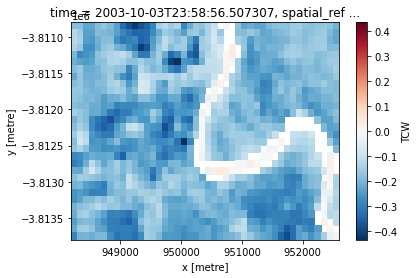

In [16]:
tcw.TCW.isel(time=101).plot()

### Reindex the stream gauge data to the TCW data

Align the stream gauge data with the TCW data by reindexing them so their dates match.

In [17]:
station_data_tcw = []
for i in range(len(station_data)):
    times = np.sort(np.unique(np.concatenate([tcw.time, station_data[i].index])))
    station_data_tcw.append(station_data[i].reindex(times).interpolate(method='nearest').reindex(tcw.time.values))

### Normalise the TCW and stream gauge data

Prepare the data for correlation estimation.

Divide the stream gauges by their maximum values to limit their range from 0 to 1:

In [19]:
stream_features = np.nan_to_num(np.array([d.values[:, 0] for d in station_data_tcw]).T)

In [20]:
stream_features /= stream_features.max(axis=0)

Repeat for the TCW data, and also reshape to collapse the spatial axes:

In [18]:
tcw_values = tcw.TCW.values

In [21]:
tcw_targets = np.nan_to_num(tcw_values.reshape(tcw_values.shape[0], -1))

In [22]:
assert tcw_targets.shape[0] == stream_features.shape[0]

In [23]:
tcw_targets /= abs(tcw_targets).max(axis=0)

## Regression slope between each time series

Calculate the linear regression slope between the stream gauge and TCW time series for each gauge and each pixel.

In [35]:
def get_correlations(stream_features, tcw_targets):
    slopes = np.zeros((stream_features.shape[1], tcw_targets.shape[1]))
    rvalues = np.zeros((stream_features.shape[1], tcw_targets.shape[1]))
    for i in range(stream_features.shape[1]):
        for pos in range(tcw_targets.shape[1]):
            lrr = scipy.stats.linregress(stream_features[:, i], tcw_targets[:, pos])
            slopes[i, pos] = lrr.slope
            rvalues[i, pos] = lrr.rvalue
    return slopes, rvalues

In [36]:
slopes, rvalues = get_correlations(stream_features, tcw_targets)

Then we can plot the slopes:

In [37]:
station_locations = gpd.GeoDataFrame(geometry=[shapely.geometry.Point(s.pos[::-1]) for s in stations_in_range], crs='EPSG:4326').to_crs(tcw.crs)

In [38]:
def plot_station_correlations(values, vmin=0, vmax=1, cmap='viridis'):
    plt.figure(figsize=(15, 20))
    for i in range(len(station_data)):
        plt.subplot(6, 3, i + 1)
        plt.pcolormesh(tcw.x, tcw.y, values[i].reshape(tcw.TCW.shape[1:]), vmin=vmin, vmax=vmax, cmap=cmap)
        plt.colorbar()
        plt.scatter(station_locations.iloc[i].geometry.x, station_locations.iloc[i].geometry.y, edgecolor='k', facecolor='w', s=100, linewidth=2)
        plt.axis('off')
        plt.scatter(station_locations.iloc[i].geometry.x, station_locations.iloc[i].geometry.y, edgecolor='k', facecolor='w', s=100, linewidth=2)
        plt.text(station_locations.iloc[i].geometry.x, station_locations.iloc[i].geometry.y, stations_in_range[i].name, c='white')
    plt.tight_layout()

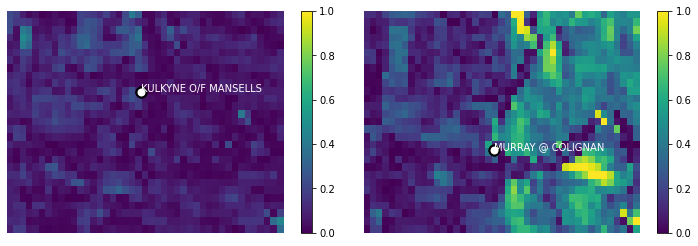

In [39]:
plot_station_correlations(abs(slopes))

There are two stream gauges in this region. One is off-stream and one is on-stream. The on-stream gauge is clearly related to the TCW values of the eastern half of the region.

## Randomly shift the data to estimate how much correlation is coincidental

Estimate how much correlation we should expect just by chance if there is no real correlation at all between the time series. To do this, shift the TCW time series so that there should be no correlation. Then repeat the above analysis. The amount of correlation detected is the expected coincidental correlation.

In [40]:
slopes_shifted, rvalues_shifted = get_correlations(stream_features, np.roll(tcw_targets, 100, axis=0))

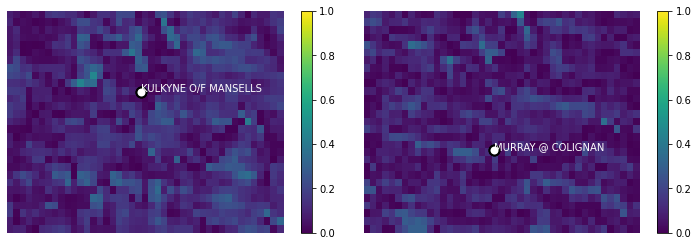

In [41]:
plot_station_correlations(abs(slopes_shifted))

In [44]:
rand_corr = abs(slopes_shifted).mean(axis=1)

print('Random correlation:')
for i in range(len(stations_in_range)):
    print(stations_in_range[i].name, rand_corr[i])

Random correlation:
KULKYNE O/F MANSELLS 0.11451669470231539
MURRAY @ COLIGNAN 0.08572042323636359


We can interpret this as a noise level and use it to mask insignificant correlations, which we will say are pixels with correlations less than 3 times the noise level:

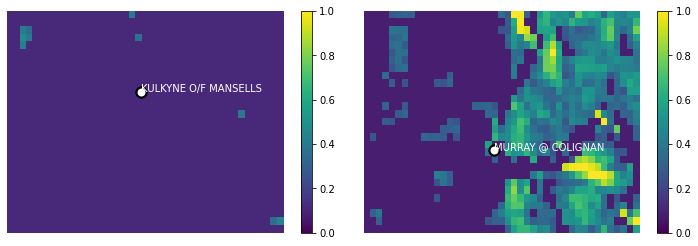

In [50]:
plot_station_correlations(np.where(abs(slopes) < 3 * rand_corr[:, None], rand_corr[:, None], abs(slopes)))

The detected correlations for the on-stream gauge seem significant.

## Conclusion

This is a very simple way of estimating the correlation between stream gauges and the surrounding landscape. Future work should investigate non-linear correlations, potential lag between stream gauges and landscape changes, and merging together identical or near-identical stream gauges (e.g. neighbouring gauges on the same river).

***

## Additional information

**License:** The code in this notebook is licensed under the [Apache License, Version 2.0](https://www.apache.org/licenses/LICENSE-2.0). 
Digital Earth Australia data is licensed under the [Creative Commons by Attribution 4.0](https://creativecommons.org/licenses/by/4.0/) license.

**Contact:** If you need assistance, please post a question on the [Open Data Cube Slack channel](http://slack.opendatacube.org/) or on the [GIS Stack Exchange](https://gis.stackexchange.com/questions/ask?tags=open-data-cube) using the `open-data-cube` tag (you can view previously asked questions [here](https://gis.stackexchange.com/questions/tagged/open-data-cube)).
If you would like to report an issue with this notebook, you can file one on [Github](https://github.com/GeoscienceAustralia/dea-notebooks).

**Last modified:** November 2020

**Compatible datacube version:**

In [187]:
datacube.__version__

'1.8.3'

## Tags